In [116]:
import numpy as np
import pandas as pd
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style("white")
import warnings
import time

import scipy as sp
from scipy.stats import norm, kurtosis
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, \
learning_curve, ShuffleSplit, KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, \
plot_confusion_matrix, classification_report, silhouette_samples, silhouette_score
#from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn import mixture
from sklearn.decomposition import FastICA
from sklearn import random_projection
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors
import tensorflow as tf;

# Data Loading and Preprocessing

In [2]:
# Import dataset

df_raw = pd.read_csv('SarsCoV2.csv', sep=";")
df_raw.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID
0,CHEMBL1200371,FROVATRIPTAN SUCCINATE,0,361.40,0,1.34,Frovatriptan succinate,CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1.O=C(O)CC...,Inhibition index,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303097,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4295411
1,CHEMBL2105345,PROPANIDID,4,337.42,0,2.44,Propanidid,CCCOC(=O)Cc1ccc(OCC(=O)N(CC)CC)c(OC)c1,Inhibition index,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303097,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4295411
2,CHEMBL354541,LOMITAPIDE,4,693.73,2,8.38,Lomitapide,O=C(NC1CCN(CCCCC2(C(=O)NCC(F)(F)F)c3ccccc3-c3c...,Inhibition index,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303097,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4295411
3,CHEMBL4303354,NaN,0,885.10,2,2.90,Acetyl spiramycin,CO[C@@H]1[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]...,Inhibition index,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303097,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4295411
4,CHEMBL1201012,FLURANDRENOLIDE,4,436.52,0,2.50,Flurandrenolide,CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)...,Inhibition index,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303097,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4295411


# Feature Generation Based on Chemical Structures

## Molecuar descriptors

In [3]:
# Load molecular descriptors as new dataframe

df = pd.read_csv('SarsCoV2_descriptors.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Molecule ChEMBL ID,Smiles,Standard Value,Cat,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CHEMBL1200371,CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1.O=C(O)CC...,0.2706,0,11.254750,-1.076481,11.254750,0.296296,0.542151,361.398,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL2105345,CCCOC(=O)Cc1ccc(OCC(=O)N(CC)CC)c(OC)c1,0.1570,0,11.989998,-0.273812,11.989998,0.045706,0.613651,337.416,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL354541,O=C(NC1CCN(CCCCC2(C(=O)NCC(F)(F)F)c3ccccc3-c3c...,-0.2950,0,13.716096,-4.532206,13.716096,0.077313,0.129689,693.732,...,0,0,0,0,0,0,0,0,1,0
3,CHEMBL4303354,CO[C@@H]1[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]...,1.2760,1,13.440349,-1.486566,13.440349,0.029280,0.190698,885.102,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL1201012,CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)...,-0.0113,0,15.479612,-1.353940,15.479612,0.045706,0.691028,436.520,...,0,0,0,0,0,0,0,0,0,0


## Morgan fingerprints

,Molecule ChEMBL ID,Smiles,Standard Value,Cat,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,ROMol
0,CHEMBL1200371,CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1.O=C(O)CC...,0.2706,0,11.254750,-1.076481,11.254750,0.296296,0.542151,361.398,...,0,0,0,0,0,0,0,0,0,
1,CHEMBL2105345,CCCOC(=O)Cc1ccc(OCC(=O)N(CC)CC)c(OC)c1,0.1570,0,11.989998,-0.273812,11.989998,0.045706,0.613651,337.416,...,0,0,0,0,0,0,0,0,0,
2,CHEMBL354541,O=C(NC1CCN(CCCCC2(C(=O)NCC(F)(F)F)c3ccccc3-c3c...,-0.2950,0,13.716096,-4.532206,13.716096,0.077313,0.129689,693.732,...,0,0,0,0,0,0,0,1,0,
3,CHEMBL4303354,CO[C@@H]1[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]...,1.2760,1,13.440349,-1.486566,13.440349,0.029280,0.190698,885.102,...,0,0,0,0,0,0,0,0,0,
4,CHEMBL1201012,CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)...,-0.0113,0,15.479612,-1.353940,15.479612,0.045706,0.691028,436.520,...,0,0,0,0,0,0,0,0,0,

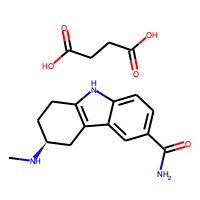
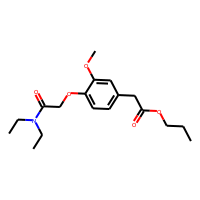
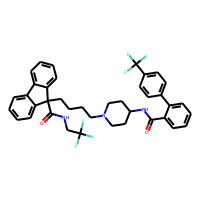
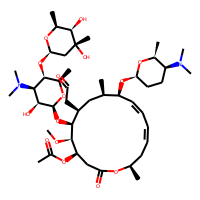
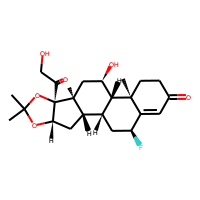

In [4]:
# Generate molecular fingerprint descriptors part 1: convert SMILES to molecular structure

PandasTools.AddMoleculeColumnToFrame(df, smilesCol='Smiles')
df.head()

In [5]:
# Generate molecular fingerprint descriptors part 2: convert structure to fingerprint vectors

mfp2_fps = rdFingerprintGenerator.GetFPs(list(df['ROMol']))
FPS = []

# Convert fingerprint vectors to numpy arrays

for fp in mfp2_fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    FPS.append(arr)
    
print('There are {} morgan fingerprint bits.'.format(len(FPS[0])))

There are 2048 morgan fingerprint bits.


In [33]:
# Split data into training and test sets
y = df['Cat']
X_train,X_test,y_train,y_test = train_test_split(FPS, y, test_size=0.2)

In [6]:
# k-means clustering
from numpy import unique
from numpy import where
from sklearn.cluster import KMeans

## Run the clustering algorithms on the datasets and describe what you see.

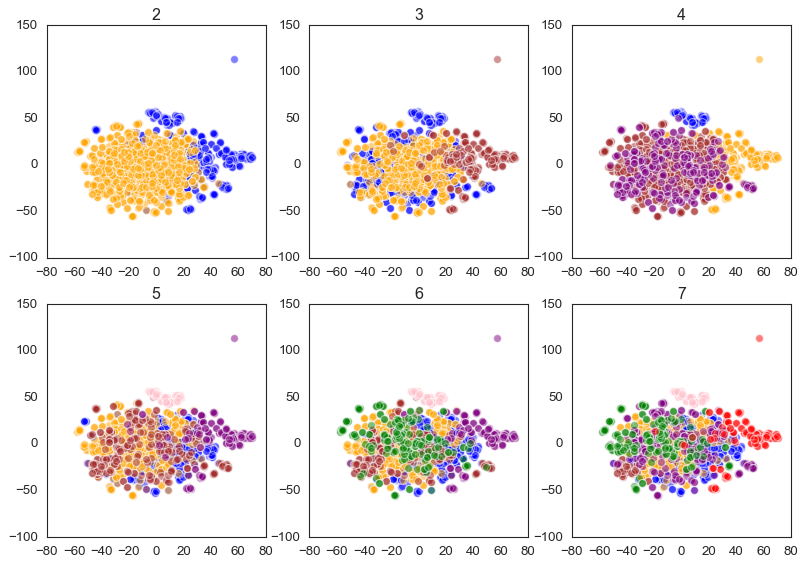

In [63]:
# let's check a few number of K's to see how many clusters would be fit for our dataset

#k-means clustering
# define the model
mpl.style.use('classic')
sns.set_style('white')
model = TSNE(n_components=2)
crds = model.fit_transform(X_train)

n_clusters = [2,3,4,5,6,7]
fig, axes = plt.subplots(2,3, figsize=(12,8))

silhouette_scores = []
for n in n_clusters:
    model = KMeans(n_clusters=n, random_state=1)
    # assign a cluster to each example
    yhat = model.fit_predict(X_train)
    # retrieve unique clusters
    clusters = unique(yhat)
    silhouette_scores.append(metrics.silhouette_score(X_train, yhat))
    # create scatter plot for samples from each cluster
    colors = ['blue', 'orange', 'brown', 'purple', 'pink', 'green', 'red']
    i=0

    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        for r in list(row_ix):
            axes[int((n-2)/3), (n-2)%3].scatter(crds[r, 0], crds[r, 1], c=colors[i], alpha=0.5, s=50)
        i += 1
    axes[int((n-2)/3), (n-2)%3].set_title(n)
# show the plot
plt.savefig('ds1_kmeans_fig3', bbox_inches='tight')

[0.06654252429358272,
 0.03355851458971097,
 0.029376207934870224,
 0.00967618538002967,
 0.010715329156353696,
 -0.0001134719649787745]

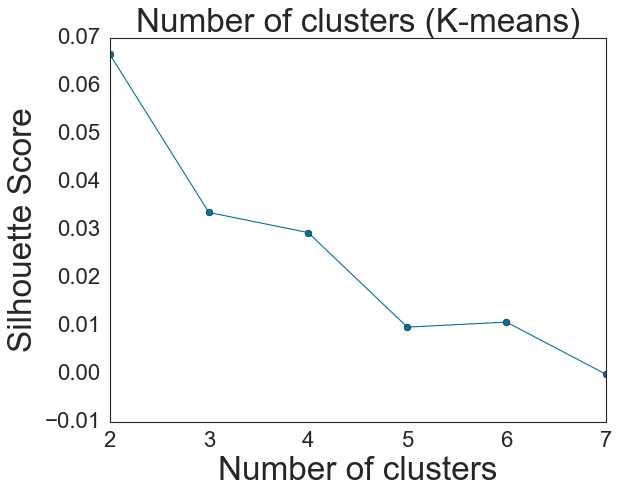

In [64]:
plt.plot(n_clusters, silhouette_scores, 'o-')
plt.title('Number of clusters (K-means)', fontsize=30)
plt.xlabel('Number of clusters', fontsize=30)
plt.ylabel('Silhouette Score', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('ds1_kmeans_fig4', bbox_inches='tight')
silhouette_scores

/anaconda3/envs/CHML/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


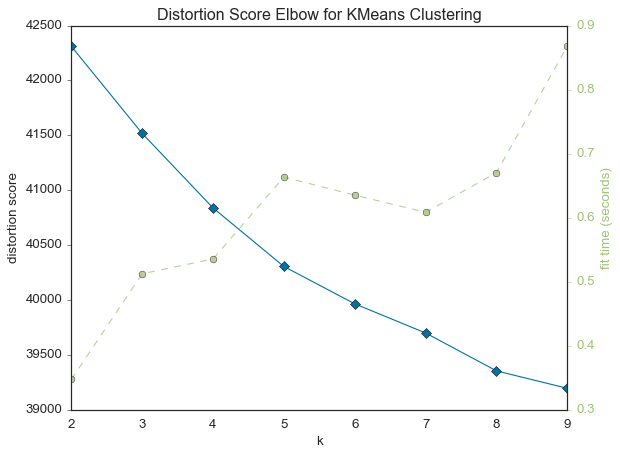

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [36]:
kelbow_visualizer(KMeans(random_state=1), np.array(X_train), k=(2,10))

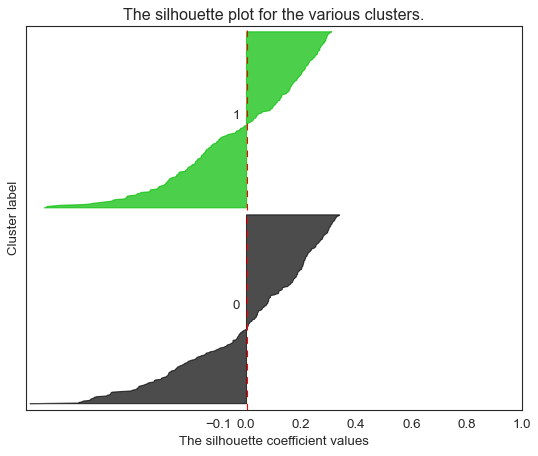

In [38]:
# Compute the silhouette scores for each sample
import matplotlib.cm as cm
def plot_silhouette_dist(n_clusters, X, clusters):
    silhouette_avg = silhouette_score(X, clusters)
    sample_silhouette_values = silhouette_samples(X, clusters)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plot_silhouette_dist(2, crds, yhat)

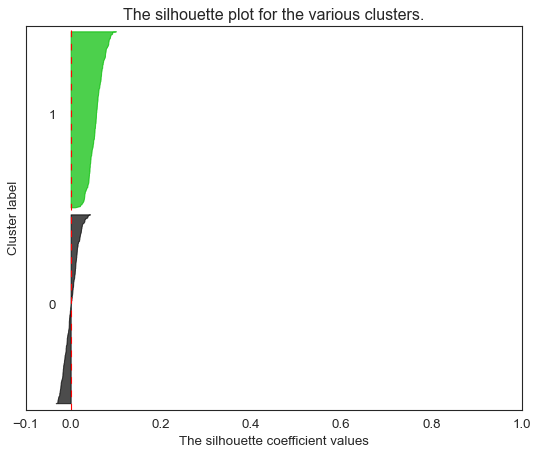

In [39]:
plot_silhouette_dist(2, X_train, yhat)

2 clusters give the highest silhouette score for K-means.

In [40]:
#store clustering infomation for NN in part 5
model = KMeans(n_clusters=2, random_state=1)
# assign a cluster to each example
kmeans_clusters = model.fit_predict(X_train)

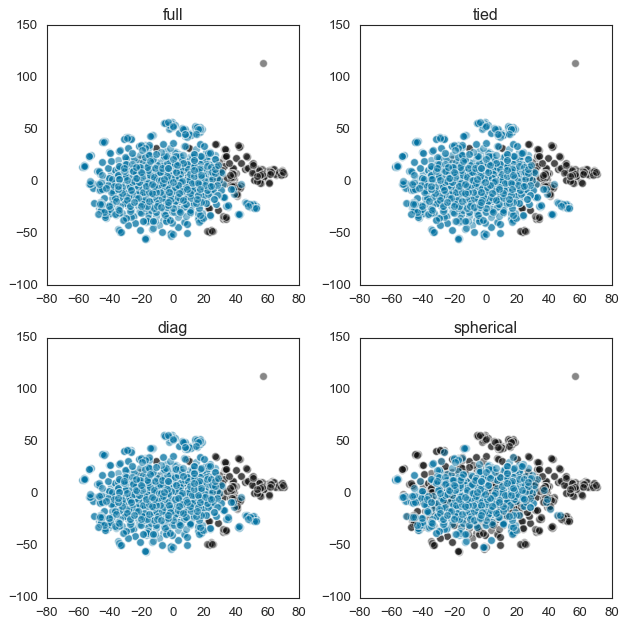

In [65]:
# Clustering using Expectation Maximization

mpl.style.use('classic')
sns.set_style('white')
types = ['full', 'tied', 'diag', 'spherical']

scores = []
fig, axes = plt.subplots(2,2, figsize=(8,8))

for t in range(len(types)):
    gmm = mixture.GaussianMixture(n_components=2, covariance_type=types[t], random_state=1).fit(X_train)
    yhat = gmm.predict(X_train)
    
    scores.append(metrics.silhouette_score(X_train, yhat))
    clusters = unique(yhat)
    colors = ['k', 'b', 'r', 'g']
    i=0
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        for r in list(row_ix):
            axes[int(t/2), t%2].scatter(crds[r, 0], crds[r, 1], c=colors[i], alpha=0.5, s=50)
        i += 1
    axes[int(t/2), t%2].set_title(types[t])
# show the plot
plt.tight_layout()
plt.savefig('ds1_em_fig5', bbox_inches='tight')

[0.0896835532233793,
 0.0896835532233793,
 0.0687067125981999,
 0.04181752552616791]

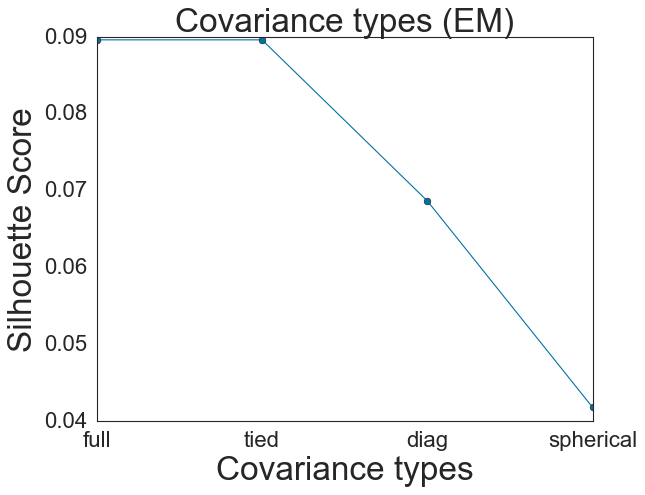

In [66]:
# find best covariance type for EM

plt.plot(types, scores, 'o-')
plt.title('Covariance types (EM)', fontsize=30)
plt.xlabel('Covariance types', fontsize=30)
plt.ylabel('Silhouette Score', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('ds1_em_fig6', bbox_inches='tight')
scores

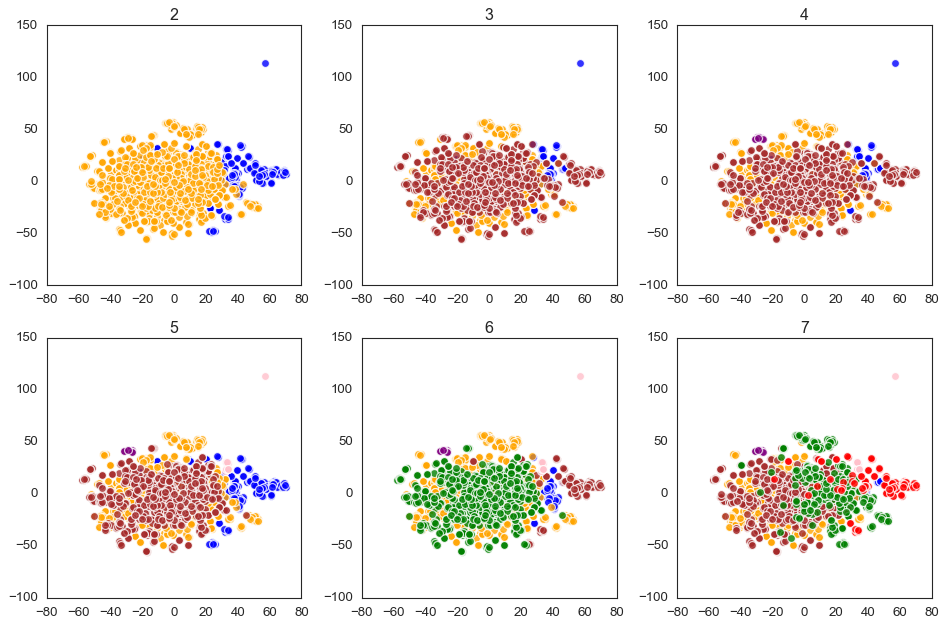

In [67]:
n_clusters = [2, 3, 4, 5, 6, 7]

scores = []
fig, axes = plt.subplots(2,3, figsize=(12,8))

for n in range(len(n_clusters)):
    gmm = mixture.GaussianMixture(n_components=n_clusters[n], covariance_type='full', random_state=1).fit(X_train)
    yhat = gmm.predict(X_train)
    
    scores.append(metrics.silhouette_score(X_train, yhat))
    clusters = unique(yhat)
    colors = ['blue', 'orange', 'brown', 'purple', 'pink', 'green', 'red']
    i=0
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        for r in list(row_ix):
            axes[int(n/3), n%3].scatter(crds[r, 0], crds[r, 1], c=colors[i], alpha=0.8, s=50)
        i += 1
    axes[int(n/3), n%3].set_title(str(n+2))
# show the plot
plt.tight_layout()
plt.savefig('ds1_em_fig7', bbox_inches='tight')

[0.0896835532233793,
 0.04007993477208482,
 0.0325271626351176,
 0.03227919149617534,
 0.03800572839373644,
 0.020455182917258504]

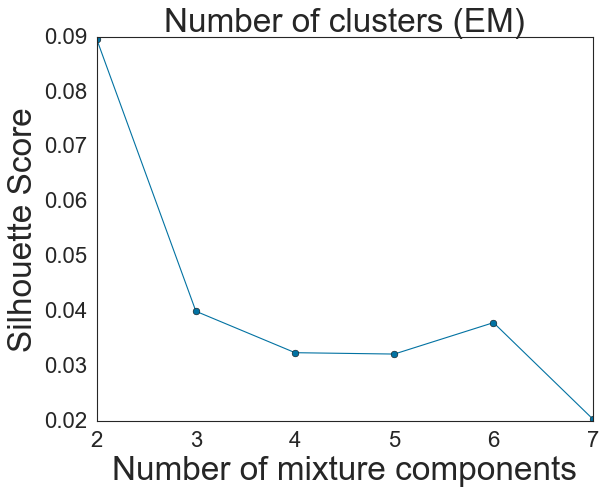

In [68]:
# find best number of clusters for EM

plt.plot(n_clusters, scores, 'o-')
plt.title('Number of clusters (EM)', fontsize=30)
plt.xlabel('Number of mixture components', fontsize=30)
plt.ylabel('Silhouette Score', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('ds1_em_fig8', bbox_inches='tight')
scores

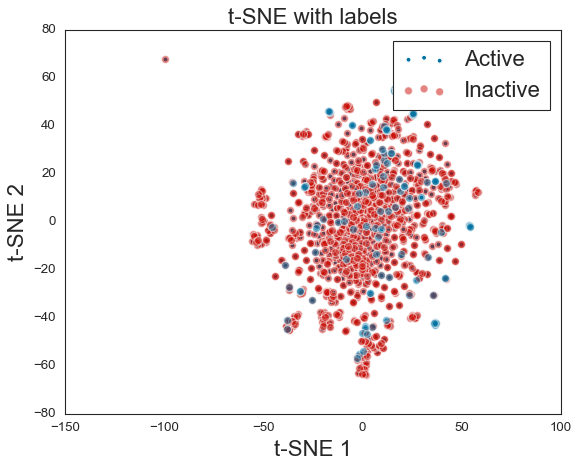

In [54]:
# first of all, the fp list has 2048 bits
# it would be great to check how the space looks like after TSNE decomposition

mpl.style.use('classic')
sns.set_style('white')
model = TSNE(n_components=2)
crds = model.fit_transform(X_train)
plt.scatter(crds[:,0], crds[:,1])

colors = ['r','b']
for i in [0, 1]:
    row_ix = where(y_train == i)
    for r in row_ix:
        plt.scatter(crds[r,0], crds[r,1], c=colors[i], alpha=0.5, s=50)

plt.legend(['Active', 'Inactive'], fontsize=20)
plt.title('t-SNE with labels', fontsize=20)
plt.xlabel('t-SNE 1', fontsize=20)
plt.ylabel('t-SNE 2', fontsize=20)
plt.savefig('ds1_tsne_fig1', bbox_inches='tight')

354


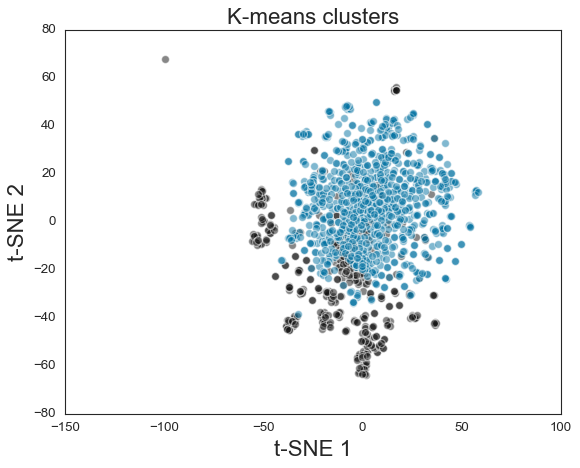

In [55]:
#k-means clustering
# define the model
model = KMeans(n_clusters=2, random_state=1)
# assign a cluster to each example
yhat = model.fit_predict(X_train)
clusters = unique(yhat)
colors = ['orchid', 'teal', 'r', 'k']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1

row_ix = where(yhat == 0)
print(len(row_ix[0]))
# show the plot
plt.title('K-means clusters', fontsize=20)
plt.xlabel('t-SNE 1', fontsize=20)
plt.ylabel('t-SNE 2', fontsize=20)
plt.savefig('ds1_kmeans_fig2', bbox_inches='tight')

In [56]:
#store clustering infomation for NN in part 5
model = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=1).fit(X_train)
# assign a cluster to each example
gmm_clusters = model.predict(X_train)

# Clustering with reduced dimension by PCA

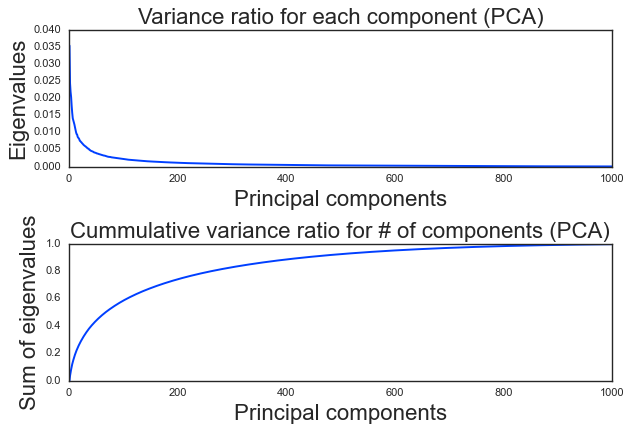

In [307]:
pca = PCA(n_components=1000, random_state=1)
crds = pca.fit_transform(X_train)
eigenvalues = pca.explained_variance_ratio_
sum_eigenvalues = [sum(eigenvalues[:n]) for n in range(1000)]
fig, axes = plt.subplots(2,1)
axes[0].plot(range(1,1001), eigenvalues)
axes[0].set_title('Variance ratio for each component (PCA)', fontsize=20)
axes[0].set_xlabel("Principal components", fontsize=20)
axes[0].set_ylabel("Eigenvalues", fontsize=20)
axes[1].plot(range(1,1001), sum_eigenvalues)
axes[1].set_title('Cummulative variance ratio for # of components (PCA)', fontsize=20)
axes[1].set_xlabel('Principal components', fontsize=20)
axes[1].set_ylabel('Sum of eigenvalues', fontsize=20)
plt.tight_layout()
plt.savefig('ds1_pca_fig16', bbox_inches='tight')

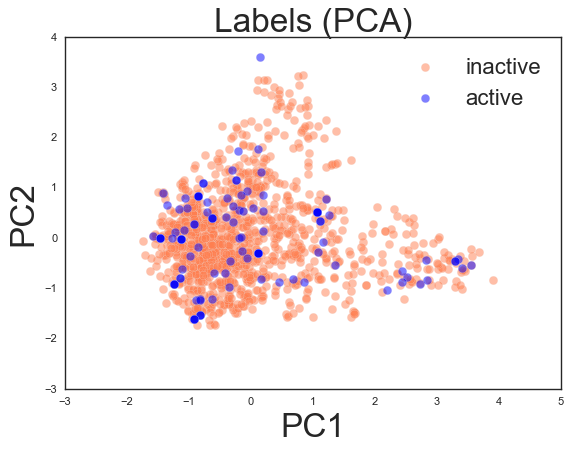

In [269]:
# Dimension Reduction
#PCA
start = time.time()

pca = PCA(n_components=400, random_state=1)
crds = pca.fit_transform(X_train)

plt.style.use('seaborn-white')
colors = ['coral','blue']
labels = ['inactive', 'active']
for i in [0, 1]:
    row_ix = where(y_train == i)
    for r in row_ix:
        plt.scatter(crds[r,0], crds[r,1], c=colors[i], alpha=0.5, s=60, label=labels[i])

colors = ['coral' if x==0 else 'blue' for x in y_train]

end = time.time()
dur = end - start
print('{} seconds'.format(dur))

plt.legend(fontsize=20)
plt.title('Labels (PCA)', fontsize=30)
plt.xlabel('PC1', fontsize=30)
plt.ylabel('PC2', fontsize=30)
plt.savefig('ds1_pca_fig9', bbox_inches='tight')

0.08002623307797711

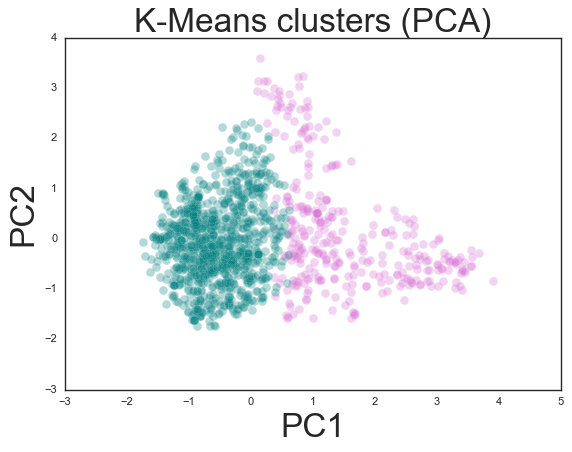

In [271]:
# Kmeans with clusters to be 2
model = KMeans(n_clusters=2, random_state=1)
# assign a cluster to each example
yhat = model.fit_predict(crds)
clusters = unique(yhat)
colors = ['orchid', 'teal', 'r', 'k']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
# show the plot
plt.title('K-Means clusters (PCA)', fontsize=30)
plt.xlabel('PC1', fontsize=30)
plt.ylabel('PC2', fontsize=30)
plt.savefig('ds1_pca_fig11', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

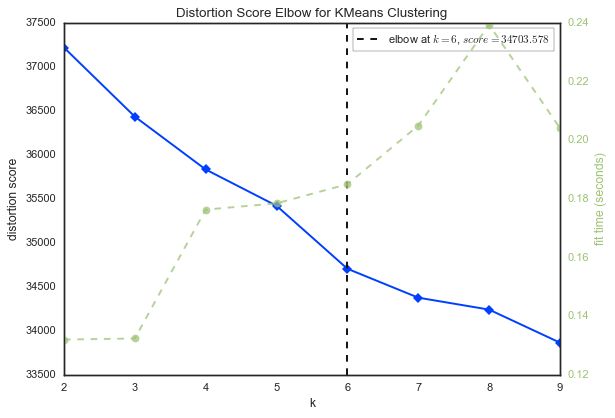

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [250]:
kelbow_visualizer(KMeans(random_state=1), crds, k=(2,10))

0.09899810958587918

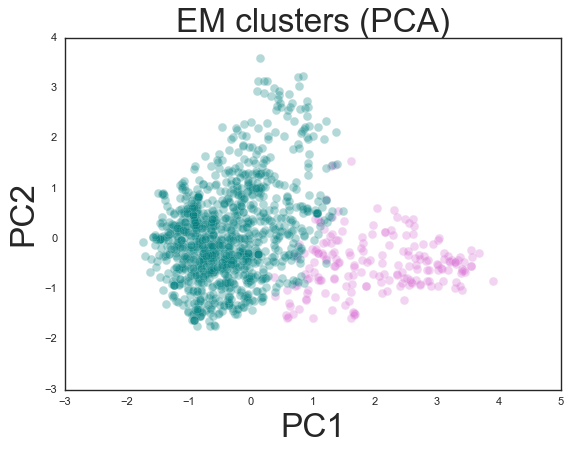

In [268]:
# expectation maximization
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=1).fit(crds)
yhat = gmm.predict(crds)

clusters = unique(yhat)
colors = ['orchid', 'teal', 'r', 'k']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
    
plt.title('EM clusters (PCA)', fontsize=30)
plt.xlabel('PC1', fontsize=30)
plt.ylabel('PC2', fontsize=30)
plt.savefig('ds1_pca_fig12', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

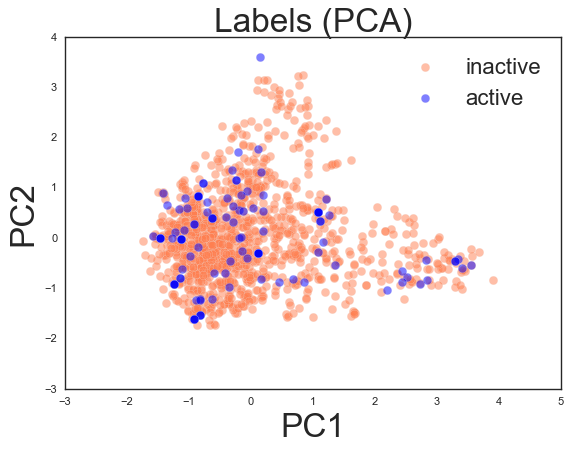

In [245]:
# Dimension Reduction
#PCA
pca = PCA(n_components=3, random_state=1)
crds = pca.fit_transform(X_train)

plt.style.use('seaborn-white')
colors = ['coral','blue']
labels = ['inactive', 'active']
for i in [0, 1]:
    row_ix = where(y_train == i)
    for r in row_ix:
        plt.scatter(crds[r,0], crds[r,1], c=colors[i], alpha=0.5, s=60, label=labels[i])

colors = ['coral' if x==0 else 'blue' for x in y_train]
plt.legend(fontsize=20)
plt.title('Labels (PCA)', fontsize=30)
plt.xlabel('PC1', fontsize=30)
plt.ylabel('PC2', fontsize=30)
plt.savefig('ds1_pca_fig13', bbox_inches='tight')

0.3351056305897174

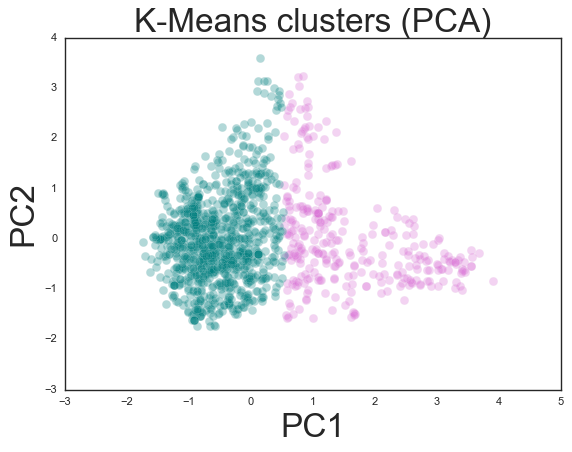

In [246]:
# Kmeans with clusters to be 2
model = KMeans(n_clusters=2, random_state=1)
# assign a cluster to each example
yhat = model.fit_predict(crds)
# retrieve unique clusters
clusters = unique(yhat)
colors = ['orchid', 'teal', 'r', 'k']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
# show the plot
plt.title('K-Means clusters (PCA)', fontsize=30)
plt.xlabel('PC1', fontsize=30)
plt.ylabel('PC2', fontsize=30)
plt.savefig('ds1_pca_fig14', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

0.3317457677264174

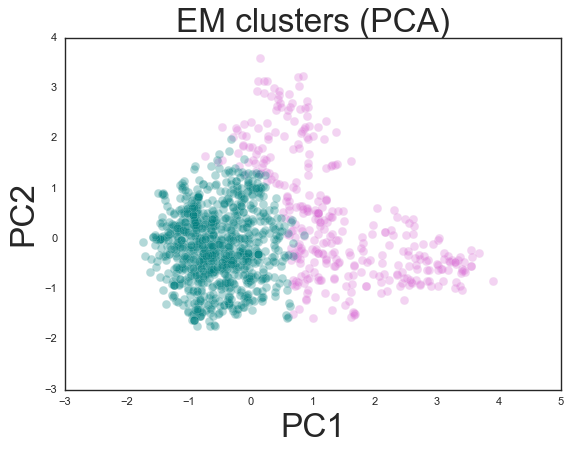

In [247]:
# expectation maximization
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=1).fit(crds)
yhat = gmm.predict(crds)

clusters = unique(yhat)
colors = ['orchid', 'teal', 'r', 'k']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
    
plt.title('EM clusters (PCA)', fontsize=30)
plt.xlabel('PC1', fontsize=30)
plt.ylabel('PC2', fontsize=30)
plt.savefig('ds1_pca_fig15', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

In [113]:
pca = PCA(n_components=400, random_state=1)
pca_train = pca.fit_transform(X_train)

# Clustering with ICA reduced dimensions

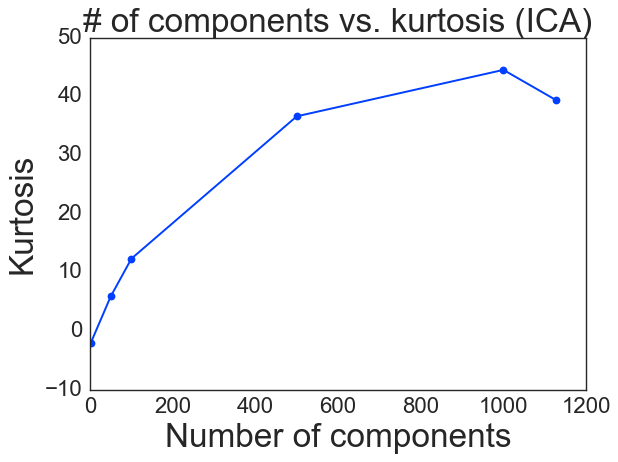

In [305]:
n_components = [2, 50, 100, 500, 1000, 1128]
kur = []
for n in n_components:
    transformer = FastICA(n_components=n, random_state=1)
    crds = transformer.fit_transform(X_train)
    kur.append(np.mean(kurtosis(transformer.components_)))

plt.title('# of components vs. kurtosis (ICA)', fontsize=30)
plt.xlabel('Number of components', fontsize=30)
plt.ylabel('Kurtosis', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(n_components, kur, 'o-')
plt.savefig('ds1_ica_fig20', bbox_inches='tight');

- best n_components is 1000, which has the largest average kurtosis

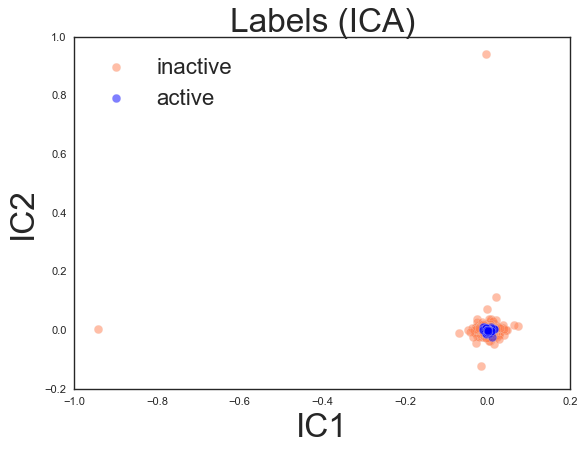

In [286]:
#ICA
start = time.time()

transformer = FastICA(n_components=1000, random_state=1)
crds = transformer.fit_transform(X_train)

plt.style.use('seaborn-white')
colors = ['coral','blue']
labels = ['inactive', 'active']
for i in [0, 1]:
    row_ix = where(y_train == i)
    for r in row_ix:
        plt.scatter(crds[r,0], crds[r,1], c=colors[i], alpha=0.5, s=60, label=labels[i])

colors = ['coral' if x==0 else 'blue' for x in y_train]

end = time.time()
dur = end - start
print('{} seconds'.format(dur))

plt.legend(fontsize=20, loc=2)
plt.title('Labels (ICA)', fontsize=30)
plt.xlabel('IC1', fontsize=30)
plt.ylabel('IC2', fontsize=30)
plt.savefig('ds1_ica_fig14', bbox_inches='tight')

0.03144747805904747

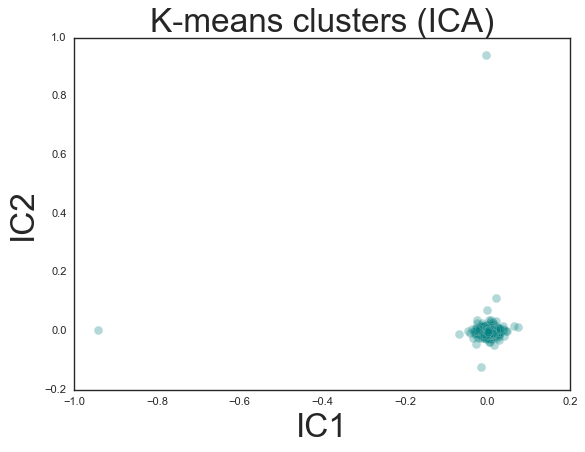

In [287]:
# Kmeans with clusters to be 2 
transformer = FastICA(n_components=1000, random_state=1)
crds = transformer.fit_transform(X_train)

model = KMeans(n_clusters=2, random_state=1)
# assign a cluster to each example
yhat = model.fit_predict(crds)
print(yhat.sum())
# retrieve unique clusters
clusters = unique(yhat)
colors = ['orchid', 'teal', 'r', 'k']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
# show the plot
plt.title('K-means clusters (ICA)', fontsize=30)
plt.xlabel('IC1', fontsize=30)
plt.ylabel('IC2', fontsize=30)
plt.savefig('ds1_ica_fig15', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

In [288]:
yhat.sum()

1248

1248


0.03144747805904747

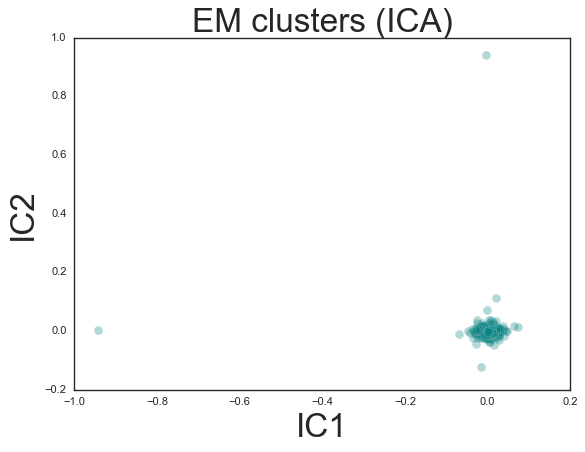

In [292]:
# expectation maximization
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=1).fit(crds)
yhat = gmm.predict(crds)
print(yhat.sum())
clusters = unique(yhat)
colors = ['orchid', 'teal', 'r', 'k']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
    
plt.title('EM clusters (ICA)', fontsize=30)
plt.xlabel('IC1', fontsize=30)
plt.ylabel('IC2', fontsize=30)
plt.savefig('ds1_ica_fig16', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

In [170]:
crds.shape

(1250, 3)

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


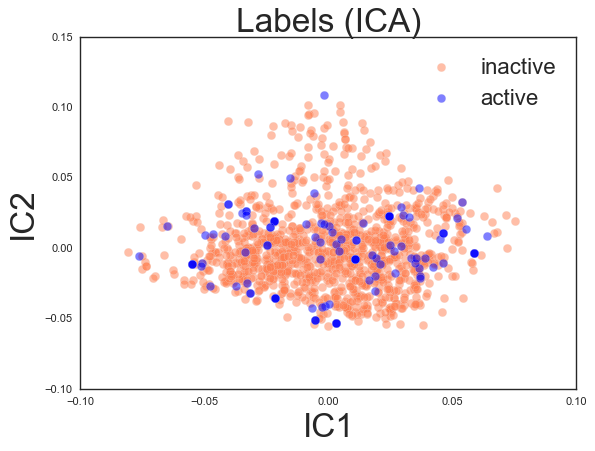

In [239]:
#ICA
start = time.time()
transformer = FastICA(n_components=3, random_state=1)
crds = transformer.fit_transform(X_train)
plt.style.use('seaborn-white')
colors = ['coral','blue']
labels = ['inactive', 'active']
for i in [0, 1]:
    row_ix = where(y_train == i)
    for r in row_ix:
        plt.scatter(crds[r,0], crds[r,1], c=colors[i], alpha=0.5, s=60, label=labels[i])

colors = ['coral' if x==0 else 'blue' for x in y_train]

end = time.time()
dur = end - start
print('{} seconds'.format(dur))
plt.legend(fontsize=20)
plt.title('Labels (ICA)', fontsize=30)
plt.xlabel('IC1', fontsize=30)
plt.ylabel('IC2', fontsize=30)
plt.savefig('ds1_ica_fig17', bbox_inches='tight')

0.2743048218646482

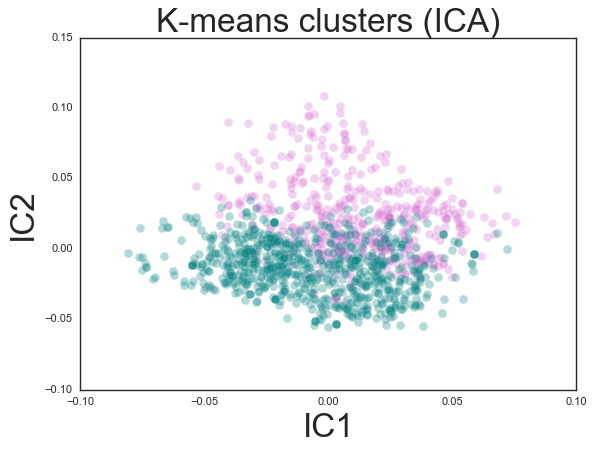

In [240]:
# Kmeans with clusters to be 2 
model = KMeans(n_clusters=2, random_state=1)
# assign a cluster to each example
yhat = model.fit_predict(crds)
# retrieve unique clusters
clusters = unique(yhat)
colors = ['orchid', 'teal', 'r', 'k']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
# show the plot
plt.title('K-means clusters (ICA)', fontsize=30)
plt.xlabel('IC1', fontsize=30)
plt.ylabel('IC2', fontsize=30)
plt.savefig('ds1_ica_fig18', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

0.2784046757511273

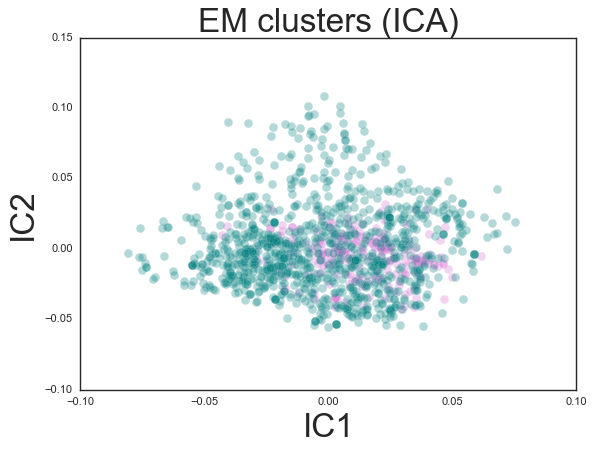

In [241]:
# expectation maximization
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=1).fit(crds)
yhat = gmm.predict(crds)

clusters = unique(yhat)
colors = ['orchid', 'teal', 'r', 'k']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
    
plt.title('EM clusters (ICA)', fontsize=30)
plt.xlabel('IC1', fontsize=30)
plt.ylabel('IC2', fontsize=30)
plt.savefig('ds1_ica_fig19', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

In [114]:
#look like the best n_components is 500
# tranform X_train with ICA and store the transformed fps into ica_train
transformer = FastICA(n_components=1000, random_state=1)
ica_train = transformer.fit_transform(X_train)

# Clustering with Randomized Projections

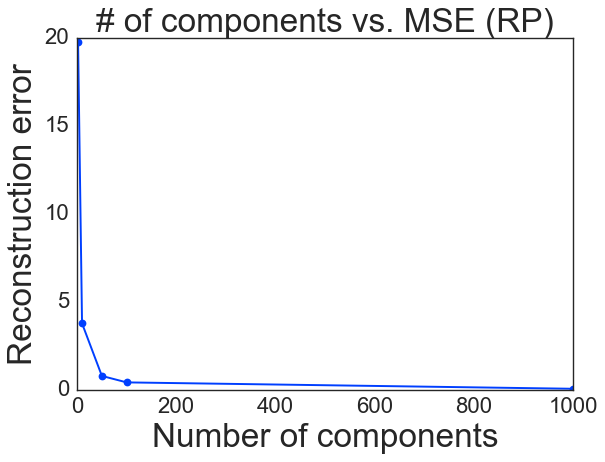

In [306]:
# look for the best n_components for RP
n_components = [2, 10, 50, 100, 1000]
mse = []
for n in n_components:
    transformer = random_projection.GaussianRandomProjection(n_components=n, random_state=1)
    crds = transformer.fit_transform(X_train)
    reconstruct = np.dot(crds, transformer.components_)
    mse.append(mean_squared_error(reconstruct, X_train))
    
plt.title('# of components vs. MSE (RP)', fontsize=30)
plt.xlabel('Number of components', fontsize=30)
plt.ylabel('Reconstruction error', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(n_components, mse, 'o-')
plt.savefig('ds1_rca_fig18', bbox_inches='tight')

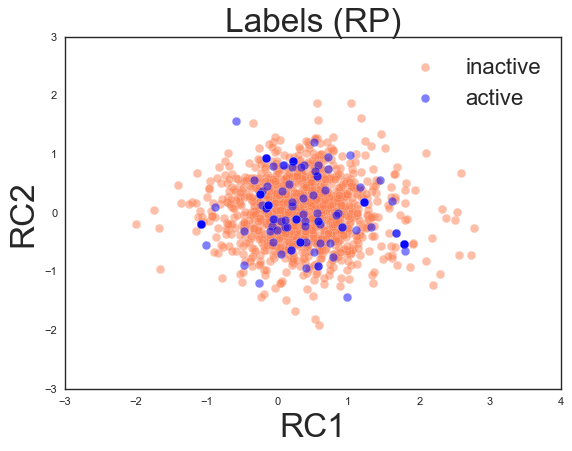

In [252]:
# Randomized Projections

start = time.time()
transformer = random_projection.GaussianRandomProjection(n_components=100, random_state=1)
crds = transformer.fit_transform(X_train)

plt.style.use('seaborn-white')
colors = ['coral','blue']
labels = ['inactive', 'active']
for i in [0, 1]:
    row_ix = where(y_train == i)
    for r in row_ix:
        plt.scatter(crds[r,0], crds[r,1], c=colors[i], alpha=0.5, s=60, label=labels[i])

colors = ['coral' if x==0 else 'blue' for x in y_train]

end = time.time()
dur = end - start
print('{} seconds'.format(dur))

plt.legend(fontsize=20)
plt.title('Labels (RP)', fontsize=30)
plt.xlabel('RC1', fontsize=30)
plt.ylabel('RC2', fontsize=30)
plt.savefig('ds1_rca_fig19', bbox_inches='tight')

0.05505157703881711

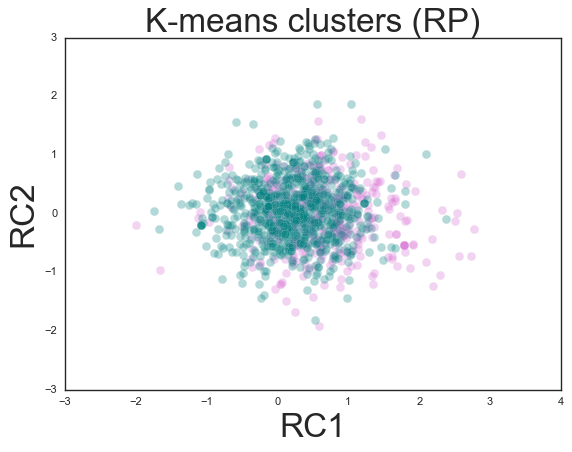

In [253]:
# Kmeans with clusters to be 2
model = KMeans(n_clusters=2, random_state=1)
# assign a cluster to each example
yhat = model.fit_predict(crds)
clusters = unique(yhat)
colors = ['orchid', 'teal', 'sienna', 'darkblue']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
# show the plot
plt.title('K-means clusters (RP)', fontsize=30)
plt.xlabel('RC1', fontsize=30)
plt.ylabel('RC2', fontsize=30)
plt.savefig('ds1_rca_fig20', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

0.0699607715157098

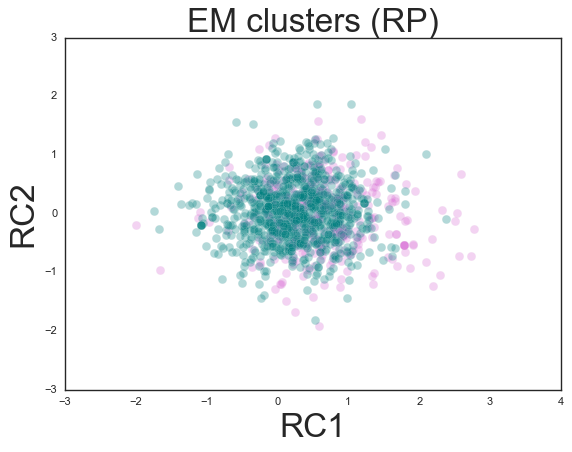

In [254]:
# expectation maximization
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=1).fit(crds)
yhat = gmm.predict(crds)

clusters = unique(yhat)
colors = ['orchid', 'teal', 'sienna', 'darkblue']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
    
plt.title('EM clusters (RP)', fontsize=30)
plt.xlabel('RC1', fontsize=30)
plt.ylabel('RC2', fontsize=30)
plt.savefig('ds1_rca_fig21', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

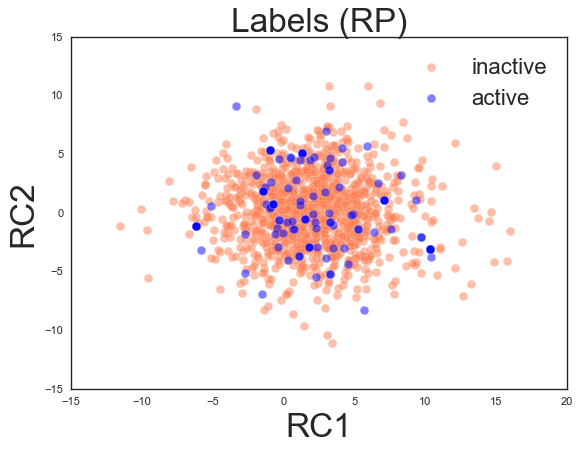

In [255]:
# Randomized Projections

transformer = random_projection.GaussianRandomProjection(n_components=3, random_state=1)
crds = transformer.fit_transform(X_train)

plt.style.use('seaborn-white')
colors = ['coral','blue']
labels = ['inactive', 'active']
for i in [0, 1]:
    row_ix = where(y_train == i)
    for r in row_ix:
        plt.scatter(crds[r,0], crds[r,1], c=colors[i], alpha=0.5, s=60, label=labels[i])

colors = ['coral' if x==0 else 'blue' for x in y_train]
plt.legend(fontsize=20)
plt.title('Labels (RP)', fontsize=30)
plt.xlabel('RC1', fontsize=30)
plt.ylabel('RC2', fontsize=30)
plt.savefig('ds1_rca_fig22', bbox_inches='tight')

0.22275225738915577

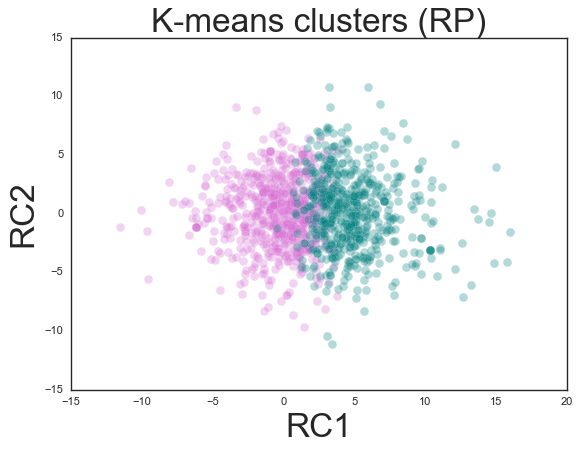

In [256]:
# Kmeans with clusters to be 2
model = KMeans(n_clusters=2, random_state=1)
# assign a cluster to each example
yhat = model.fit_predict(crds)
clusters = unique(yhat)
colors = ['orchid', 'teal', 'sienna', 'darkblue']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
# show the plot
plt.title('K-means clusters (RP)', fontsize=30)
plt.xlabel('RC1', fontsize=30)
plt.ylabel('RC2', fontsize=30)
plt.savefig('ds1_rca_fig23', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

0.22390467027080022

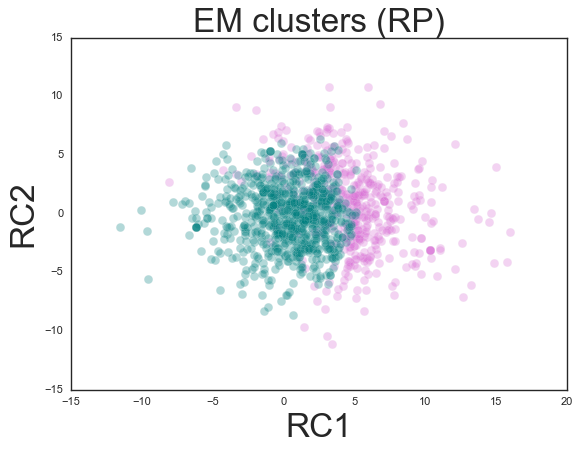

In [257]:
# expectation maximization
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=1).fit(crds)
yhat = gmm.predict(crds)

clusters = unique(yhat)
colors = ['orchid', 'teal', 'sienna', 'darkblue']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
    
plt.title('EM clusters (RP)', fontsize=30)
plt.xlabel('RC1', fontsize=30)
plt.ylabel('RC2', fontsize=30)
plt.savefig('ds1_rca_fig24', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

In [122]:
# n_components=100 has converged reconstruction error in terms of MSE
transformer = random_projection.GaussianRandomProjection(n_components=100, random_state=1)
rp_train = transformer.fit_transform(X_train)

# Clustering with NMF reduced dimension

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/s

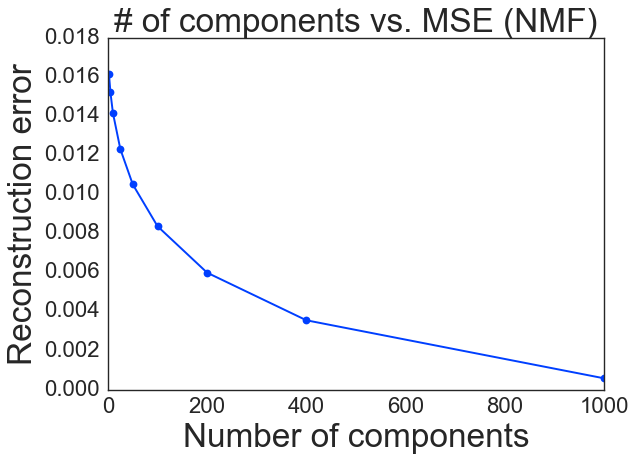

In [293]:
# look for the best n_components for NMF
from sklearn.decomposition import NMF
n_components = [2, 5, 10, 25, 50, 100, 200, 400, 1000]
mse = []
for n in n_components:
    transformer = NMF(n_components=n, init='random', random_state=1)
    crds = transformer.fit_transform(X_train)
    reconstruct = np.dot(crds, transformer.components_)
    mse.append(mean_squared_error(reconstruct, X_train))
    
plt.title('# of components vs. MSE (NMF)', fontsize=30)
plt.xlabel('Number of components', fontsize=30)
plt.ylabel('Reconstruction error', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(n_components, mse, 'o-')
plt.savefig('ds1_nmf_fig22', bbox_inches='tight')

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


35.034796953201294 seconds


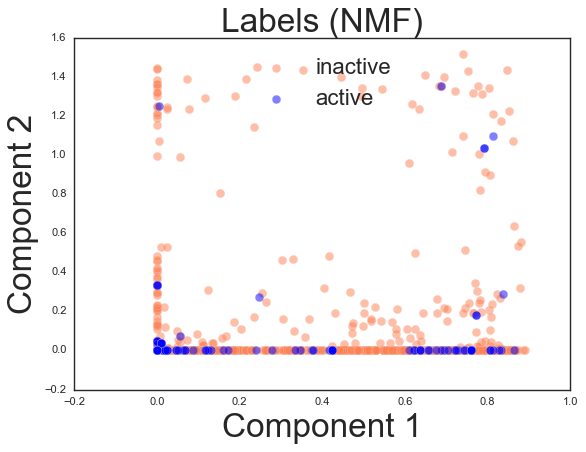

In [300]:
# non-negative matrix factorization

start = time.time()
model = NMF(n_components=200, init='random', random_state=1)
crds = model.fit_transform(X_train)

plt.style.use('seaborn-white')
colors = ['coral','blue']
labels = ['inactive', 'active']
for i in [0, 1]:
    row_ix = where(y_train == i)
    for r in row_ix:
        plt.scatter(crds[r,0], crds[r,1], c=colors[i], alpha=0.5, s=60, label=labels[i])

colors = ['coral' if x==0 else 'blue' for x in y_train]

end = time.time()
dur = end - start
print('{} seconds'.format(dur))
plt.legend(fontsize=20, loc=9)
plt.title('Labels (NMF)', fontsize=30)
plt.xlabel('Component 1', fontsize=30)
plt.ylabel('Component 2', fontsize=30)
plt.savefig('ds1_nmf_fig23', bbox_inches='tight')

0.8339784835847704

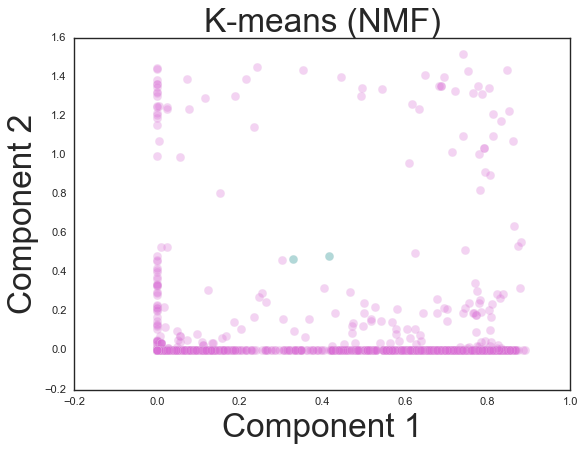

In [301]:
# Kmeans with clusters to be 2
model = KMeans(n_clusters=2, random_state=1)
# assign a cluster to each example
yhat = model.fit_predict(crds)
clusters = unique(yhat)
colors = ['orchid', 'teal', 'sienna', 'darkblue']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
# show the plot
plt.title('K-means (NMF)', fontsize=30)
plt.xlabel('Component 1', fontsize=30)
plt.ylabel('Component 2', fontsize=30)
plt.savefig('ds1_nmf_fig24', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

In [302]:
yhat.sum()

2

In [303]:
y_train.sum()/len(y_train)

0.088

0.08725692768995874

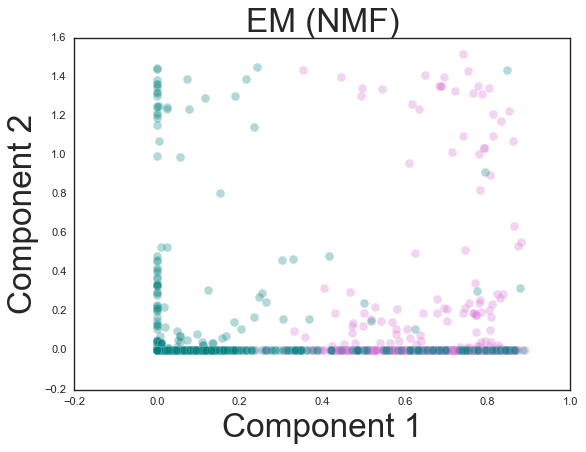

In [304]:
# expectation maximization
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=1).fit(crds)
yhat = gmm.predict(crds)

clusters = unique(yhat)
colors = ['orchid', 'teal', 'sienna', 'darkblue']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
    
plt.title('EM (NMF)', fontsize=30)
plt.xlabel('Component 1', fontsize=30)
plt.ylabel('Component 2', fontsize=30)
plt.savefig('ds1_nmf_fig25', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


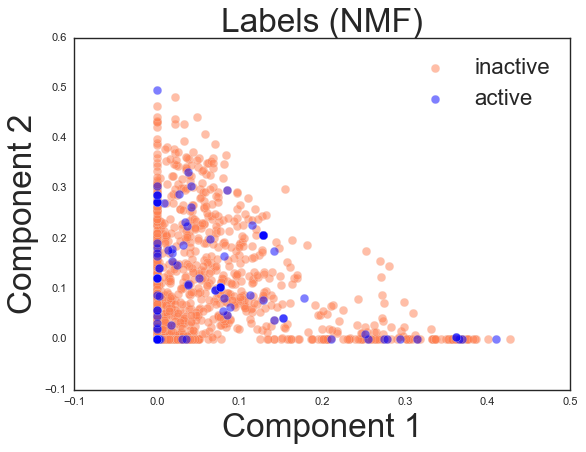

In [261]:
# non-negative matrix factorization

model = NMF(n_components=3, init='random', random_state=1)
crds = model.fit_transform(X_train)

plt.style.use('seaborn-white')
colors = ['coral','blue']
labels = ['inactive', 'active']
for i in [0, 1]:
    row_ix = where(y_train == i)
    for r in row_ix:
        plt.scatter(crds[r,0], crds[r,1], c=colors[i], alpha=0.5, s=60, label=labels[i])

colors = ['coral' if x==0 else 'blue' for x in y_train]
plt.legend(fontsize=20)
plt.title('Labels (NMF)', fontsize=30)
plt.xlabel('Component 1', fontsize=30)
plt.ylabel('Component 2', fontsize=30)
plt.savefig('ds1_nmf_fig26', bbox_inches='tight')

0.397185069410915

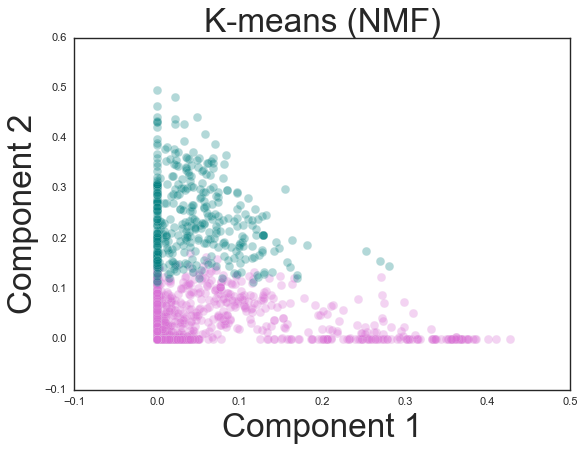

In [262]:
# Kmeans with clusters to be 2
model = KMeans(n_clusters=2, random_state=1)
# assign a cluster to each example
yhat = model.fit_predict(crds)
clusters = unique(yhat)
colors = ['orchid', 'teal', 'sienna', 'darkblue']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
# show the plot
plt.title('K-means (NMF)', fontsize=30)
plt.xlabel('Component 1', fontsize=30)
plt.ylabel('Component 2', fontsize=30)
plt.savefig('ds1_nmf_fig27', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

0.3999491948399654

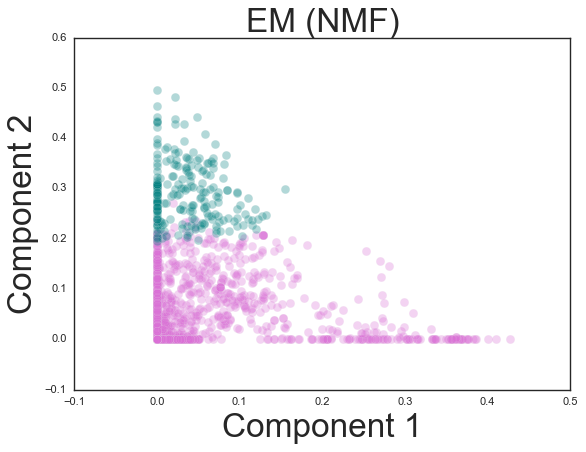

In [263]:
# expectation maximization
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=1).fit(crds)
yhat = gmm.predict(crds)

clusters = unique(yhat)
colors = ['orchid', 'teal', 'sienna', 'darkblue']
i=0
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    for r in list(row_ix):
        plt.scatter(crds[r, 0], crds[r, 1], c=colors[i], s=60, alpha=0.3)
    i += 1
    
plt.title('EM (NMF)', fontsize=30)
plt.xlabel('Component 1', fontsize=30)
plt.ylabel('Component 2', fontsize=30)
plt.savefig('ds1_nmf_fig28', bbox_inches='tight')
metrics.silhouette_score(crds, yhat)

In [181]:
transformer = NMF(n_components=100, init='random', random_state=1)
nmf_fps = transformer.fit_transform(FPS)

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


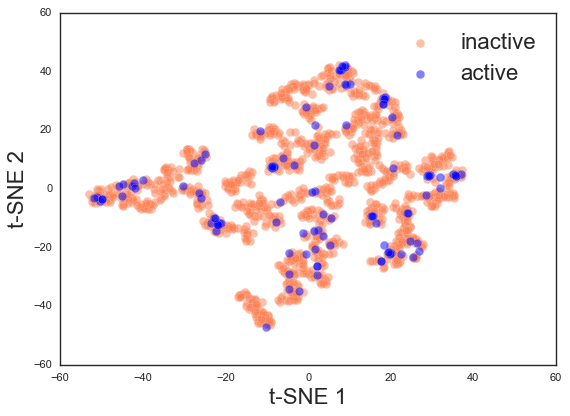

In [265]:
# visualization with TSNE + PCA decomposition

pca = PCA(n_components=2)
crds = pca.fit_transform(X_train)
model = TSNE(n_components=2)
tsne_crds = model.fit_transform(crds)

plt.style.use('seaborn-white')
colors = ['coral','blue']
labels = ['inactive', 'active']
for i in [0, 1]:
    row_ix = where(y_train == i)
    for r in row_ix:
        plt.scatter(tsne_crds[r,0], tsne_crds[r,1], c=colors[i], alpha=0.5, s=60, label=labels[i])

colors = ['coral' if x==0 else 'blue' for x in y_train]
plt.legend(fontsize=20)
plt.xlabel('t-SNE 1', fontsize=20)
plt.ylabel('t-SNE 2', fontsize=20)
plt.savefig('ds1_tsnepca_fig10', bbox_inches='tight')